# Neural Networks 6

## Sequential data

We are interested to process sequential data where the output depends on previous inputs $x_t$ and outputs $y_t$

$$
y_t = f(x_t, x_{t-1},\ldots,x_0,y_{t-1},y_{t-2},\ldots,y_0)
$$

These have been studied also in the context of neural networks already some time.

## Recurrent Neural network (RNN)

In their paper

 * A.J. Robinson and F. Fallside (1987): "Static and Dynamic Error Propagation Networks with Application to Speech Coding". In the Proceedings of the Neural Information Processing Systems (NeurIPS). [PDF](https://proceedings.neurips.cc/paper/1987/file/a1d0c6e83f027327d8461063f4ac58a6-Paper.pdf)
 
Robinson and Fallside proposed neural network based solution to a dynamic system. For more information about training such system, see

 * https://en.wikipedia.org/wiki/Backpropagation_through_time

## Long Short-Term Memory (LSTM)

Inspired by the idea of Robinson and Fallside the idea was extended in

 * S. Hochreiter and J. Schmidhuber (1997): "Long Short-term Memory". In Neural Computation, Vol. 9, No. 8. [PDF](https://www.researchgate.net/publication/13853244_Long_Short-term_Memory)
 
but their paper is rather difficult to read. Therefore, you may have a look on Wikipedia

 * https://en.wikipedia.org/wiki/Long_short-term_memory

<div>
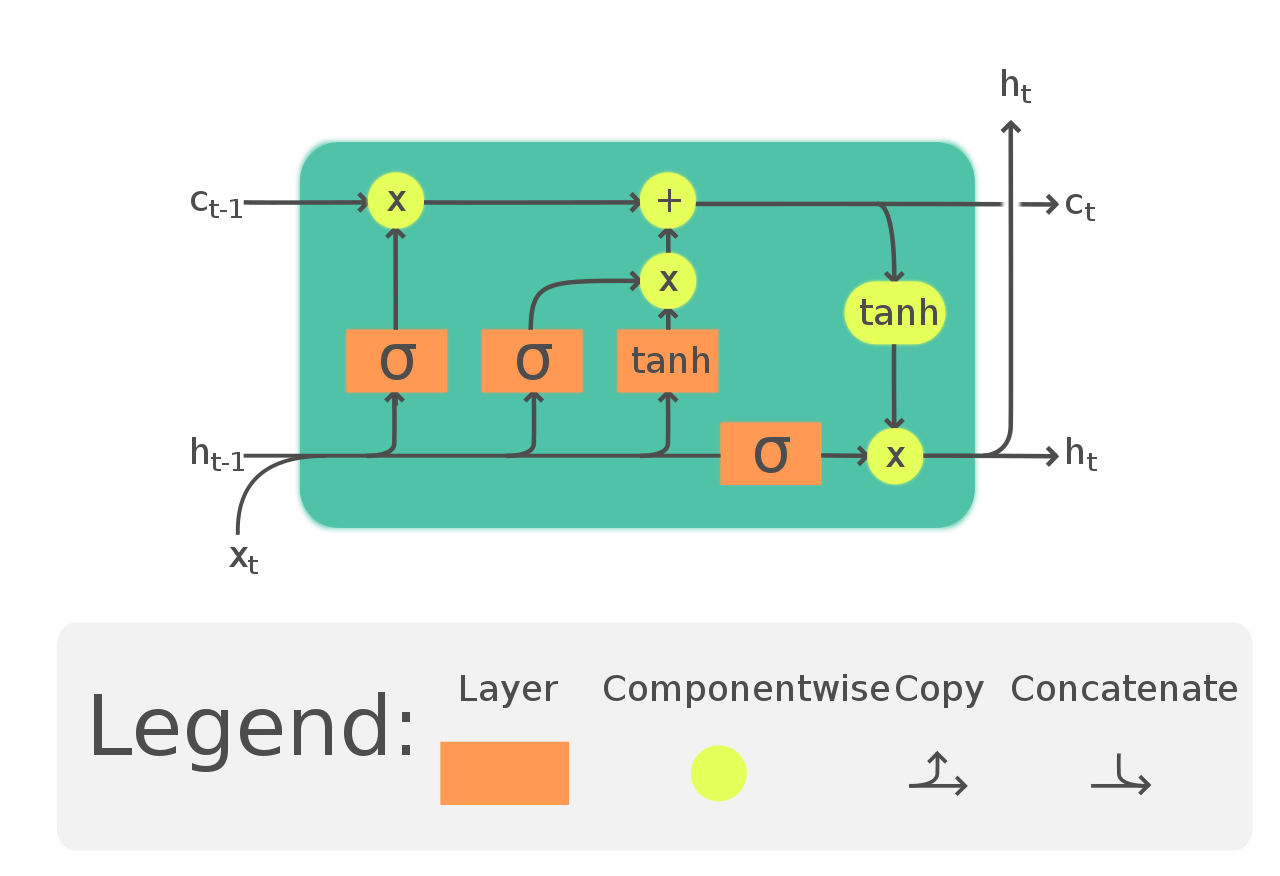
</div>

or even better, Colah's excellent blog post

 * https://colah.github.io/posts/2015-08-Understanding-LSTMs/

### The vanishing gradient problem

The main working principle of LSTMs is that they allow the context vector $c_t$ pass unchanged if the new inputs do not provide important information. For this explanation see

 * https://medium.datadriveninvestor.com/how-do-lstm-networks-solve-the-problem-of-vanishing-gradients-a6784971a577?gi=8cc7cd9d3e1f

## The ultimate sequential challenge: Natural language

As always, Andrej Karpathy's blog posts are enoyable and educative to read about a specific topic you want understand better:

 - http://karpathy.github.io/2015/05/21/rnn-effectiveness/

<div>
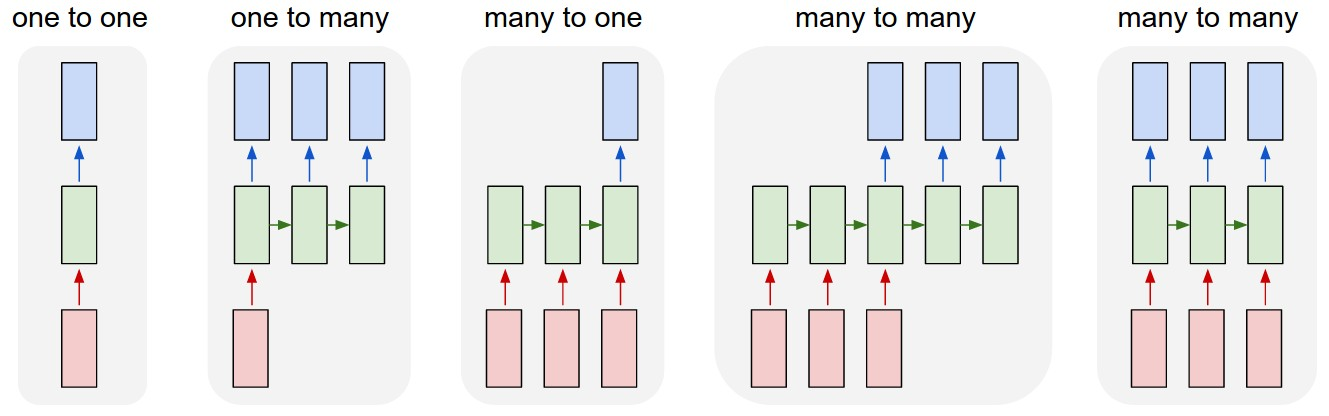
</div>



#### Demo: Text Generation with an RNN (your tiny ChatGPT)
Code for this demo is largely taken from the TensorFlow tutorial at
 - https://www.tensorflow.org/text/tutorials/text_generation
 
 and it is essentially based on the work
 
  * I. Sutskever, O. Vinyals, and Q.V. Le (2014): "Sequence to Sequence Learning with Neural Networks" in Proc. of the Neural Information Processing Systems (NeurIPS). [PDF](https://proceedings.neurips.cc/paper/2014/file/a14ac55a4f27472c5d894ec1c3c743d2-Paper.pdf)

Import TensorFlow and some necessary libs (tested on TensorFlow 2.11.0 and Keras 2.11.0)

In [1]:
import tensorflow as tf
print(f'TensorFlow version {tf.__version__}')
print(f'Keras version {tf.keras.__version__}')

import numpy as np
import os
import time

TensorFlow version 2.12.0
Keras version 2.12.0


#### Loading data and basic processing of textual data

Download the Shakespeare dataset (Kartpathy generated this by concatenating all Shakespeare's plays)

In [2]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 1s 1us/step


Load the dataset file and print out some basic statistics

In [3]:
print(f'The dataset storage path: {path_to_file}')

# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

# Take a look at the first 250 characters in text
print(f'\n STARTS First 250 characters --------')
print(text[:250])
print(f'-------- First 250 characters ENDS\n')

# The unique characters in the file
vocab = sorted(set(text))
print(f'Text includes {len(vocab)} unique characters (note that some of them might be spelling mistakes:)')

print(vocab)

The dataset storage path: C:\Users\mahad\.keras\datasets\shakespeare.txt
Length of text: 1115394 characters

 STARTS First 250 characters --------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

-------- First 250 characters ENDS

Text includes 65 unique characters (note that some of them might be spelling mistakes:)
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


#### Vectorizing the textual data to integers suitable for neural networks

Before training, you need to convert the strings to a numerical representation.

The tf.keras.layers.StringLookup layer can convert each character into a numeric ID. It just needs the text to be split into tokens first.

In [4]:
# Convert UTF characters to unique IDs
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

# Let's test with the first 250 characters
example_txt = ['JONI', 'joni', 'Joo']
print(example_txt)
chars = tf.strings.unicode_split(example_txt, input_encoding='UTF-8')
print(chars)
ids = ids_from_chars(chars)
print(ids)

# Inversion process
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

chars = chars_from_ids(ids)
print(chars)

example_txt = tf.strings.reduce_join(chars, axis=-1).numpy()
print(example_txt)
print(example_txt[0].decode('ASCII'))

['JONI', 'joni', 'Joo']
<tf.RaggedTensor [[b'J', b'O', b'N', b'I'], [b'j', b'o', b'n', b'i'], [b'J', b'o', b'o']]>
<tf.RaggedTensor [[23, 28, 27, 22], [49, 54, 53, 48], [23, 54, 54]]>
<tf.RaggedTensor [[b'J', b'O', b'N', b'I'], [b'j', b'o', b'n', b'i'], [b'J', b'o', b'o']]>
[b'JONI' b'joni' b'Joo']
JONI


A small subfunction that converts character ids back to characters

In [5]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)


Let's construct training batches where input is 100 characters and output is the most likely next (101st) character. Below the idea is demonstrated. We also use the tf.data.Dataset class that provides nice handling for large datasets, for example, to partition them into batches.

 * https://www.tensorflow.org/guide/data

In [6]:
# Note that the "text" variable contains all Shakespeare
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
print(all_ids[0:9])

ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

seq_length = 100

# Format the raw dataset into "batches" of 101 characters (later split to 0:99 and 1:100)
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())


tf.Tensor([19 48 57 58 59  2 16 48 59], shape=(9,), dtype=int64)
F
i
r
s
t
 
C
i
t
i
tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)
b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll 

Let's make a data splitter routine that converts original 101 lenght signals to 100 length input (0:99) and 100 length output (1:100)

In [7]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

split_input_target(list("Tensorflow"))


(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

Dataset is constructed from whole text material using the pre-processed sequences and mapping them using the splitter routine.

In [8]:
dataset = sequences.map(split_input_target)

for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())


Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


#### Network construction and training

In [9]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

Eeach token is represented by embedding that is similar to one-hot-encoding. Each RNN unit corresponds to a single neuron in MLPs or one filter in CNNs.

In [10]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())
print(vocab_size)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

66


The network architecture is an encode-decoder with a single LSTM element (GRU) of embedding dimension 256 

In [11]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [15]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

This model cannot be realized until we have some example data to build it.

In [19]:
# Model is not implemented before some data examples
model.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  16896     
                                                                 
 gru_1 (GRU)                 multiple                  3938304   
                                                                 
 dense_1 (Dense)             multiple                  67650     
                                                                 
Total params: 4,022,850
Trainable params: 4,022,850
Non-trainable params: 0
_________________________________________________________________


Let's give the model one batch of training data to realize it.

In [17]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

model.summary()

(64, 100, 66) # (batch_size, sequence_length, vocab_size)
Input:
 b"e it; in the name o' the people\nAnd in the power of us the tribunes, we,\nEven from this instant, ban"

Next Char Predictions:
 b"OAf-oZ BRpm[UNK]vOVIheP,'lYWuFKw.OQogfxgrBHAntAY3FFJx[UNK]OloK,q;B\nZfbpYEzf L,TJUprCai3$3'AcwOQmhgocYBFTu?ux"
Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  16896     
                                                                 
 gru_1 (GRU)                 multiple                  3938304   
                                                                 
 dense_1 (Dense)             multiple                  67650     
                                                                 
Total params: 4,022,850
Trainable params: 4,022,850
Non-trainable params: 0
_________________________________________________________________


In [18]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

tf.exp(example_batch_mean_loss).numpy()

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.19043, shape=(), dtype=float32)


66.0512

In [20]:
model.compile(optimizer='adam', loss=loss)

In [21]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [22]:
EPOCHS = 1 # Improves upto 50 and then starts to overfit

history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

  3/172 [..............................] - ETA: 33:04 - loss: 4.1480

KeyboardInterrupt: 

You may also load one checkpoint file (below you might be interested to test checkpoints 1..20)

In [27]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)
load_model = 'training_checkpoints/ckpt_1'
model.load_weights(load_model)

None


NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for training_checkpoints/ckpt_1

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch-1')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Stored training image for 100 epochs

<div>
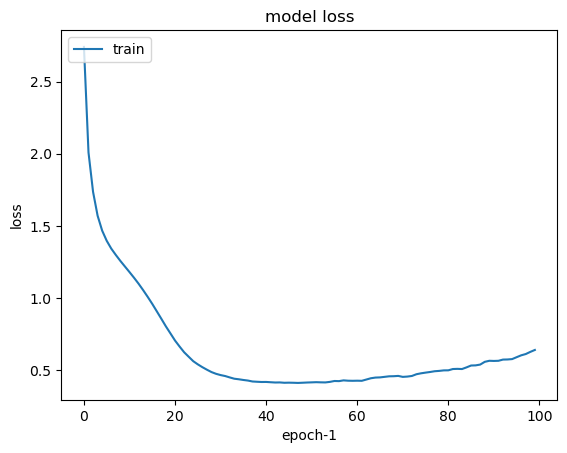
</div>

Let's test the model with an example sequence - why this looks pretty full of errors?

In [25]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model.predict(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")
    
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

2/2 [==============================] - 6s 2s/step
(64, 100, 66) # (batch_size, sequence_length, vocab_size)
Input:
 b'r tragedy.\nI tell thee, Catesby--\n\nCATESBY:\nWhat, my lord?\n\nHASTINGS:\nEre a fortnight make me elder,'

Next Char Predictions:
 b'cjcmV$ButUE  [UNK]:onds a e d t     o                                                                   '


Yes, because the model is not allowed to express its freedom, but enforced to a new input every time. Let's next allow it freely generate text.

In [26]:
inputs = 'R'
states = None
result = [inputs]


for n in range(500):
    inputs = [inputs]
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = ids_from_chars(input_chars)
    pred_logits,states = model(input_ids,states,return_state=True)
    pred_logits = pred_logits.to_tensor()
    pred_logits=pred_logits[-1]
    pred_ids = tf.random.categorical(pred_logits, num_samples=1)
    pred_ids = tf.squeeze(pred_ids, axis=-1)
    inputs = text_from_ids(pred_ids).numpy()
    inputs = inputs.decode('ASCII')
    result.append(inputs)

example_txt = tf.strings.reduce_join(result, axis=-1).numpy()
print(example_txt.decode('ASCII'))

RfZr[UNK]Lxk?donFl.?opchBrseXxh Ruonsu h   r     o  
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

## References

Read the papers cited above.